In [1]:
# config env
pkgs_path = "/bohr/pkgs-7x29/v1/pkgs"
llava_lib_path = "/bohr/libb-bg5b/v1/llava"
model_path = "/bohr/1111-ggy7/v1/table-llava-v1.5-7b"
tsr_model_path = "/bohr/tsrr-sjv7/v1/table-structure-recognition-v1.1-all"
# model_path = "/bohr/1111-oxpj/v2/llava-v1.6-vicuna-7b"
cache_path = "/bohr/cache-3bi6/v1/cache"
# pkgs_path = "/personal/pkgs"
# llava_lib_path = "/personal/llava"
model_path = "/personal/model/table-llava-v1.5-7b"
# cache_path = "/personal/cache"

!pip install {pkgs_path}/*
!cp {llava_lib_path} . -r
!cp {cache_path} . -r

import os

# 提交时可能不能联网，设置成离线模式防止联网失败报错
os.environ['TRANSFORMERS_OFFLINE'] = '1'
os.environ['HF_DATASETS_OFFLINE'] = '1'
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ["HUGGINGFACE_HUB_CACHE"] = "./cache"
os.environ["HF_HOME"] = "./cache"

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Processing /bohr/pkgs-7x29/v1/pkgs/MarkupSafe-2.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /bohr/pkgs-7x29/v1/pkgs/PyYAML-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /bohr/pkgs-7x29/v1/pkgs/accelerate-0.21.0-py3-none-any.whl
Processing /bohr/pkgs-7x29/v1/pkgs/aiofiles-23.2.1-py3-none-any.whl
Processing /bohr/pkgs-7x29/v1/pkgs/altair-5.3.0-py3-none-any.whl
Processing /bohr/pkgs-7x29/v1/pkgs/annotated_types-0.7.0-py3-none-any.whl
Processing /bohr/pkgs-7x29/v1/pkgs/anyio-4.4.0-py3-none-any.whl
Processing /bohr/pkgs-7x29/v1/pkgs/attrs-24.2.0-py3-none-any.whl
Processing /bohr/pkgs-7x29/v1/pkgs/bitsandbytes-0.43.3-py3-none-manylinux_2_24_x86_64.whl
Processing /bohr/pkgs-7x29/v1/pkgs/certifi-2024.7.4-py3-none-any.whl
Processing /bohr/pkgs-7x29/v1/pkgs/charset_normalizer-3.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /bohr/pkgs-7x29/v1/pkgs/cl

In [2]:
from llava.constants import (
    IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN
)
from llava.conversation import Conversation
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import (
    process_images,
    tokenizer_image_token,
    get_model_name_from_path,
)
from llava.conversation import SeparatorStyle

import torch
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import os
import json
from PIL import Image, ImageDraw

/opt/mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
args = type('Args', (), {
    "model_path": model_path,
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "conv_mode": None,
    "sep": ",",
    "temperature": 0,
    "top_p": 1,
    "num_beams": 1,
    "max_new_tokens": 4
})()
torch.cuda.empty_cache()
disable_torch_init()

model_name = get_model_name_from_path(args.model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    args.model_path, args.model_base, model_name,
    local_files_only=True,
    cache_dir="./cache",
    # use_flash_attn=True,
    # load_4bit=True
)

tsr_img_processor = AutoImageProcessor.from_pretrained(tsr_model_path)
tsr_img_processor.size['shortest_edge'] = image_processor.size['shortest_edge']
tsr_model = TableTransformerForObjectDetection.from_pretrained(tsr_model_path)
label2id = tsr_model.config.label2id
label_row = label2id['table row']
label_col = label2id['table column']

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/opt/mamba/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [02:13<00:00, 66.82s/it]
Some weights of the model checkpoint at /personal/model/table-llava-v1.5-7b were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.visio

In [4]:
if os.environ.get('DATA_PATH_B'):  # 提交时会选择隐藏的测试数据集路径（A+B榜），数据集的格式与A榜数据相同，但数目不同（5360张）
    base_dir = os.environ.get('DATA_PATH_B')
else:
    base_dir = '/bohr/form-recognition-train-b6y2/v4'  # 示例，把A榜测试数据集路径作为测试集路径，仅开发时挂载A榜数据用于debug   # 示例，把A榜测试数据集路径作为测试集路径，仅开发时挂载A榜数据用于debug

In [5]:
with open(os.path.join(base_dir, 'dataset.json'), 'r') as f:
    data = json.load(f)

# with open(os.path.join(base_dir, 'sample_submission.json'), 'r') as f:
#     sub = json.load(f)

In [6]:
def tsr_process(raw_image):
    image = raw_image.copy()
    inputs = tsr_img_processor(images=image, return_tensors="pt")
    outputs = tsr_model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])  # (height, width) of each image in the batch
    results = tsr_img_processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
    draw = ImageDraw.Draw(image)
    rows = 0
    cols = 0
    for label, box in zip(results["labels"], results["boxes"]):
        label, box = label.item(), box.tolist()
        draw.rectangle(box, outline="red", width=1)

        if label == label_row:
            rows += 1
        elif label == label_col:
            cols += 1
    return image, rows, cols


def one_image(img_path, qs_list):
    image = Image.open(img_path).convert("RGB")
    tsr_image, rows, cols = tsr_process(image)
    image_sizes = [
        image.size,
        tsr_image.size
    ]
    images_tensor = [
        process_images([image], image_processor, model.config)[0].unsqueeze(0).half().cuda(),
        process_images([tsr_image], image_processor, model.config)[0].unsqueeze(0).half().cuda()
    ]
    out_list = []
    with torch.inference_mode():
        for qs in qs_list:
            idx = 1 if 'row' in qs or 'col' in qs else 0
            qs = DEFAULT_IMAGE_TOKEN + "\n" + qs
            conv = Conversation(
                system="A conversation between a curious human and an AI assistant about the contents of a table image. The assistant should give only an integer as answer to each question, with no extra explanation.",
                roles=["Human", "Assistant"],
                messages=[
                ],
                offset=2,
                sep_style=SeparatorStyle.SINGLE,
                sep="###",
            )
            conv.append_message(conv.roles[0], qs)
            conv.append_message(conv.roles[1], None)
            prompt = conv.get_prompt()
            input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).cuda()

            output_ids = model.generate(
                input_ids,
                images=images_tensor,
                image_sizes=image_sizes,
                do_sample=True if args.temperature > 0 else False,
                temperature=args.temperature,
                top_p=args.top_p,
                num_beams=args.num_beams,
                max_new_tokens=args.max_new_tokens,
                use_cache=True,
            )
            outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
            out_list.append(outputs)
    return out_list

In [7]:
from collections import defaultdict
ans = defaultdict(lambda: -1)
for i, letter in enumerate('ABCD'):
    ans[letter] = i
sub_list = ('Physics', 'Mathematics', 'ComputerScience', 'QuantitativeBiology', 'QuantitativeFinance', 'Statistics',
                'ElectricalEngineeringandSystemsScience', 'Economics', '')
def clean_out(image_path, out_list):
    response1 = out_list[0]
    response21 = out_list[1]
    response22 = out_list[2]
    response3 = out_list[3]
    try:
        response1 = int(response1)
        if 0 <= response1 <= 7:
            pass
        else:
            response1 = -1
    except:
        response1 = -1
    try:
        rows = int(response21)
    except:
        rows = -1
    try:
        cols = int(response22)
    except:
        cols = -1
    sub_item = {
        "image_path": image_path,
        "category": sub_list[response1],
        "cols": cols,
        "rows": rows,
        "answer": ans[response3],
    }
    return sub_item

In [8]:
submission = []

for item in data:
    image_path = os.path.join(base_dir, 'test_images', item["image_path"])
    qs_list = [
        f'This table caption: "{item["caption"]}". Based on the provided table and caption, select the most relevant subject from ([0]Physics, [1]Mathematics, [2]ComputerScience, [3]QuantitativeBiology, [4]QuantitativeFinance, [5]Statistics, [6]ElectricalEngineeringandSystemsScience, [7]Economics), just answer the serial num:',
        f'Based on this table, how many rows are in this table? Just answer an exact integer:',
        f'Based on this table, how many cols are in this table? Just answer an exact integer:',
        f"""Based on this table, for the question: "{item["question"]}", select the most correct option from (A. {item["options"][0]}, B. {item["options"][1]}, C. {item["options"][2]}, D. {item["options"][3]}). Answer with the option's letter from the given choices directly."""
    ]
    out_list = one_image(image_path, qs_list)
    sub_item = clean_out(item["image_path"], out_list)
    submission.append(sub_item)

with open('submission.json', 'w') as f:
    json.dump(submission, f)

Based on this table, for the question: "What is the difference between the Monte Carlo value and the Upper Bound value for a cluster size of $5$ as shown in the table?", select the most correct option from (A.$0.7967$, B.$0.4916$, C.$0.2697$, D.0.6605). Answer with the option's letter from the given choices directly.
['1', '7', '8', 'Based on the table']
{'image_path': '136dc674-b45b-4b32-92cb-8905a32530fd.png', 'category': 'Mathematics', 'cols': 8, 'rows': 7, 'answer': -1}


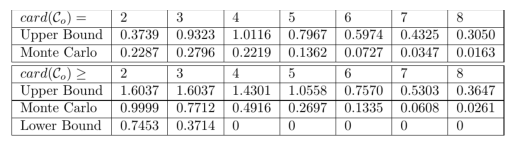

Based on this table, for the question: "What is the purpose of the 'Edges to ID' field according to the table?", select the most correct option from (A.Mapping mmWave links to IDs, B.Observation space that will be used by SB3., C.Number of steps of the current episode., D.List of data to compare with heuristics based algorithms.). Answer with the option's letter from the given choices directly.
['2', '13', '10', 'A']
{'image_path': '5a2bdb38-4d49-47d3-bd15-9fbbb050cce9.png', 'category': 'ComputerScience', 'cols': 10, 'rows': 13, 'answer': -1}


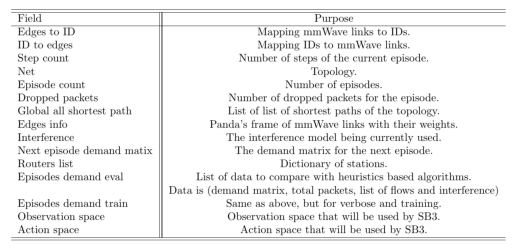

Based on this table, for the question: "Which model has the lowest Hamming Loss according to the training performance data on the Senwave COVID-19 training dataset?", select the most correct option from (A.BD-LSTM, B.LSTM, C.BERT, D.All models have the same Hamming Loss). Answer with the option's letter from the given choices directly.
['2', '6', '6', 'A']
{'image_path': '22aba16d-a7dd-492b-91db-332f518ac7fe.png', 'category': 'ComputerScience', 'cols': 6, 'rows': 6, 'answer': -1}


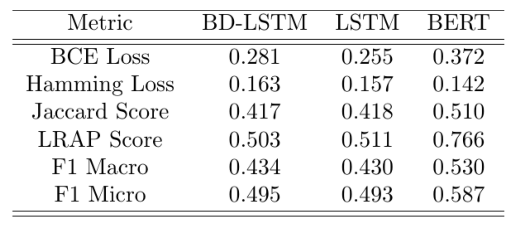

Based on this table, for the question: "Which data set has the highest number of local optima according to the table?", select the most correct option from (A.cifar100, B.mnist., C.iris., D.wine.). Answer with the option's letter from the given choices directly.
['1', '9', '8', 'B']
{'image_path': 'a9bd1865-8e81-4f09-9f3d-5585921e1c51.png', 'category': 'Mathematics', 'cols': 8, 'rows': 9, 'answer': -1}


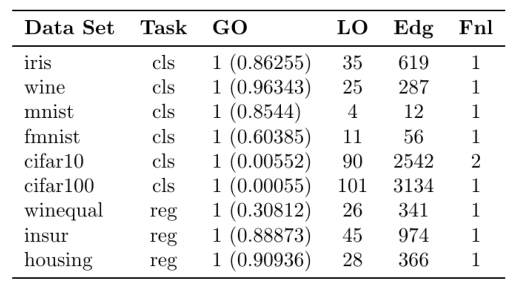

Based on this table, for the question: "What is the difference in average time $T_{avg}$ between the MILP formulation and GRASP for instance A5?", select the most correct option from (A.1.63 seconds., B.57.18 seconds., C.55.55 seconds, D.0.84 seconds.). Answer with the option's letter from the given choices directly.
['1', '6', '10', 'Based on the table']
{'image_path': '9bf636da-93e1-4fb6-ba41-e06df2bf1ca3.png', 'category': 'Mathematics', 'cols': 10, 'rows': 6, 'answer': -1}


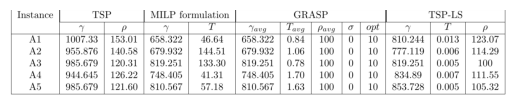

In [34]:
submission = []

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
idx = 100
num = 5
start = time.perf_counter()
for item in data[idx: idx + num]:
    image_path = os.path.join(base_dir, 'test_images', item["image_path"])
    qs_list = [
        f'This table caption: "{item["caption"]}". Based on the provided table and caption, select the most relevant subject from ([0]Physics, [1]Mathematics, [2]ComputerScience, [3]QuantitativeBiology, [4]QuantitativeFinance, [5]Statistics, [6]ElectricalEngineeringandSystemsScience, [7]Economics), just answer the serial num:',
        f'Based on this table, how many rows are in this table? Just answer an exact integer:',
        f'Based on this table, how many cols are in this table? Just answer an exact integer:',
        f"""Based on this table, for the question: "{item["question"]}", select the most correct option from (A. {item["options"][0]}, B. {item["options"][1]}, C. {item["options"][2]}, D. {item["options"][3]}). Answer with the option's letter from the given choices directly."""
    ]
    out_list = one_image(image_path, qs_list)
    sub_item = clean_out(item["image_path"], out_list)
    submission.append(sub_item)
    print(qs_list[-1])
    print(out_list)
    print(sub_item)
    img = mpimg.imread(image_path)

    # 显示图片
    plt.imshow(img)
    plt.axis('off')  # 不显示坐标轴
    plt.show()
end = time.perf_counter()
print("AVG TIME: ", (end - start) / num)

In [ ]:
# img1_path = "/personal/img1.jpg"
# img2_path = "/personal/img2.jpg"
# img1, img2 = Image.open(img1_path).convert("RGB"), Image.open(img2_path).convert("RGB")
# image_sizes = [img1.size, img2.size]
# # images_tensor = process_images([image, tsr_image], image_processor, model.config)[0].unsqueeze(0).half().cuda()
# images_tensor = process_images(
#     [img1, img2],
#     image_processor,
#     model.config
# ).to(model.device, dtype=torch.float16)
# conv = Conversation(
#     system=f"A conversation between human and assistant.",
#     roles=["Human", "Assistant"],
#     messages=[],
#     offset=2,
#     sep_style=SeparatorStyle.SINGLE,
#     sep="###",
# )
# out_list = []
# qs = "There are two images: cat image <image>\n and dog image <image>\n.Can you decribe they ?<image>\n."
# with torch.inference_mode():
#     conv.append_message(conv.roles[0], qs)
#     conv.append_message(conv.roles[1], None)
#     prompt = conv.get_prompt()
#     input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(
#         0).cuda()

#     output_ids = model.generate(
#         input_ids,
#         images=images_tensor,
#         image_sizes=image_sizes,
#         do_sample=True if args.temperature > 0 else False,
#         temperature=args.temperature,
#         top_p=args.top_p,
#         num_beams=args.num_beams,
#         max_new_tokens=512,
#         use_cache=True,
#     )
#     outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
#     conv.messages[-1][1] = outputs
#     print(prompt)
#     print("-" * 20)
#     print(outputs)